# Speech Command Recognition

We will build an audio classifier network for recognizing trigger commands.

### Setup

In [18]:
!pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torchviz

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=c6f06df7f81cbbd82274b0cb777663c43d023f5483f859b5a752a09cc81ee04e
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd
from torchviz import make_dot

from tqdm import tqdm

#select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Dataset

We use torchaudio to download and represent the dataset. Here we use
[SpeechCommands](https://arxiv.org/abs/1804.03209), which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

In [32]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

#helper class to split data into training, validation and test sets
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
valid_set = SubsetSC("validation")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0] #sample for visualizations

Find all labels in dataset:

In [11]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))

Sample input waveform:

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


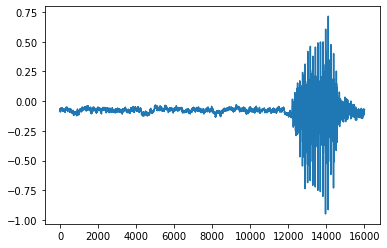

In [5]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

### Data Processing

For data transformations, we can downsample the audio for faster procesing without losing much classification power. We choose to not do any further processing since SpeechCommands uses a single channel for audio.

Word encoding and lookup helper functions:

In [12]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

Collate data to turn list of data points into 2 batched tensors; Apply padding so tensors have consistent shape:

In [36]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

#constants
batch_size = 256
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

#create dataloaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
valid_loader = torch.utils.data.DataLoader(
    valid_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

### Network Definition

We will build a CNN following the M5 network architecture explained in paper [Very Deep Convolutional Neural Networks for Raw Waveforms](https://arxiv.org/pdf/1610.00087.pdf).

Note an important aspect for models processing raw audio is the receptive field of their first layers' filers. Our model's first layer has length 80, and we process audio samples at 8kHz, so we get a receptive field near 10ms which is fine.

In [65]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)


### Training

#### Loss Metric
We will use negative log likelihood loss.

#### Optimization
Following the paper [Very Deep Convolutional Neural Networks for Raw Waveforms](https://arxiv.org/pdf/1610.00087.pdf), we will use an Adam optimizer with weight decay set to 0.0001, and learning rate scheduler starting at 0.01, decreasing to 0.001 over 20 epochs.

In [66]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

Training function:

In [67]:
def train(model, epoch, log_interval):
  train_loss = []
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
      data = data.to(device)
      target = target.to(device)

      # apply transform and model on whole batch directly on device
      data = transform(data)
      output = model(data)

      # negative log-likelihood for a tensor of size (batch x 1 x n_output)
      loss = F.nll_loss(output.squeeze(), target)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # print training stats
      if batch_idx % log_interval == 0:
          print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
          
      # record loss
      train_loss.append(loss.item())

  #return final loss
  return train_loss[-1]

Testing function:

In [68]:
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    return tensor.argmax(dim=-1)

def test(model, epoch, dataldr, name):
    model.eval()
    correct = 0
    loss = 0
    with torch.no_grad():
      for data, target in dataldr:
          data = data.to(device)
          target = target.to(device)

          # apply transform and model on whole batch directly on device
          data = transform(data)
          output = model(data)

          pred = get_likely_index(output)
          correct += number_of_correct(pred, target)

          loss += F.nll_loss(output.squeeze(), target)

      print(f"{name} -  Epoch: {epoch}\tAccuracy: {correct}/{len(dataldr.dataset)} ({100. * correct / len(dataldr.dataset):.0f}%)")
    
    return 100 * correct / len(dataldr.dataset), loss / len(dataldr.dataset)

Train and test network:

In [ ]:
#constants
log_interval = 20
n_epoch = 21

pbar_update = 1 / (len(train_loader) + len(test_loader))
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
      #training
      train(model, epoch, log_interval)
      print()
      train_acc, train_loss = test(model, epoch, train_loader, "Train Set")
      #validating
      valid_acc, valid_loss = test(model, epoch, valid_loader, "Valid Set")
      print()
      #record
      train_losses.append(train_loss)
      train_accs.append(train_acc)
      valid_losses.append(valid_loss)
      valid_accs.append(valid_acc)
      #scheduler update
      scheduler.step()


Visualize results of training

In [ ]:
# summarize history for accuracy
plt.plot(train_accs)
plt.plot(valid_accs)
plt.title('model accuracy')
plt.ylabel = 'accuracy'
plt.xlabel = 'epoch'
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('model loss')
plt.ylabel = 'loss'
plt.xlabel = 'epoch'
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Model Evaluation

Testing set results:

In [70]:
test(model, epoch, valid_loader, "Test Set")

Test Set -  Epoch: 21	Accuracy: 8709/9981 (87%)


(87.25578599338743, tensor(0.0017, device='cuda:0'))

Prediction helper function:

In [71]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor

#### Open Testing

We can create our own test by recording a sample while executing the cell below:

In [76]:
def record(seconds=1):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)

Recording started for 1 seconds.


<IPython.core.display.Javascript object>

Recording ended.
Predicted: wow.
